In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path = 'ontario_data/'
#current day
df3 = pd.read_csv(path + 'conposcovidloc(4-11).csv')
df3.columns = [x.lower() for x in df3.columns]
tor_df = df3.loc[df3['reporting_phu_city']=='Toronto']
tor_df = tor_df.groupby('accurate_episode_date')
df3 = df3.groupby('accurate_episode_date')



X3 = df3.count().iloc[:,1]    # for ontario
region = 'Ontario'


# X3 = tor_df.count().iloc[:,1]   # for toronto
# region = 'Toronto'

X3.drop(X3.tail(2).index,inplace=True)

In [3]:
from math import exp, sqrt
from scipy import optimize


#guassian function
def fx(x, a,b,c):
    return a*np.exp(-(x-b)**2/(2*(c**2)))


rsquare: 0.9427315630052414


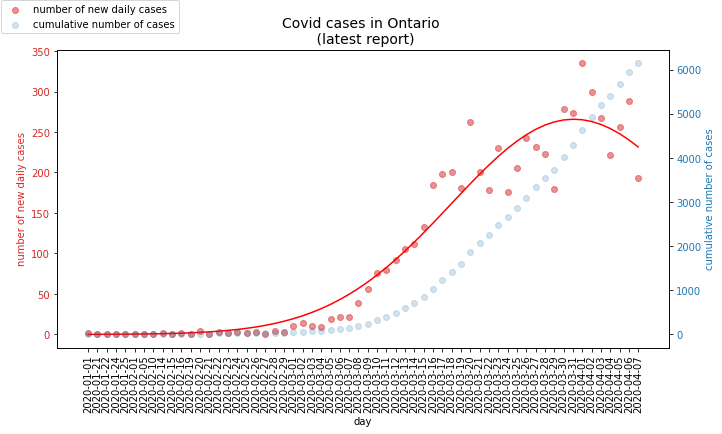

In [4]:
# Figure 2
Xc = pd.DataFrame(X3)


Xc['total'] = Xc.cumsum()
Xc = Xc.reset_index(drop=False)

Xc = Xc.rename(columns={'accurate_episode_date':'date', 'age_group': 'daily'})



data1 = [Xc['date'], Xc['daily']]
data2 = [Xc['date'], Xc['total']]

fig, ax1 = plt.subplots(facecolor='w', figsize=(10,6))

color = 'tab:red'
ax1.set_xlabel('day')
ax1.set_ylabel('number of new daily cases', color=color)
ax1.scatter(*data1, color=color, alpha = 0.5, label='number of new daily cases')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=90)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('cumulative number of cases', color=color)  # we already handled the x-label with ax1
ax2.scatter(*data2, color=color, alpha=0.2, label = 'cumulative number of cases')
ax2.tick_params(axis='y', labelcolor=color)

Xx = np.array(Xc.index)
yy = np.array(Xc['daily'])

# regression
bounds = ([50,15,0],[20000,90,20])
params, params_cov = optimize.curve_fit(fx,Xx,yy, bounds=bounds)
# print(params)

# residuals
residuals = yy - fx(Xx,*params)
ssres = np.sum(residuals**2)
sstot = np.sum((yy-np.mean(yy))**2)
rsquared = 1-(ssres/sstot)
print('rsquare: {}'.format(rsquared))

ax1.plot(fx(Xx,*params), c='r')
ax1.set_title('Covid cases in {} \n (latest report)'.format(region), fontsize=14)

fig.legend(borderaxespad=0.1, loc='upper left')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.tight_layout()
# plt.savefig('./o_figures/figure2.png', dpi=300)


plt.show()


C:\Users\Eric\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


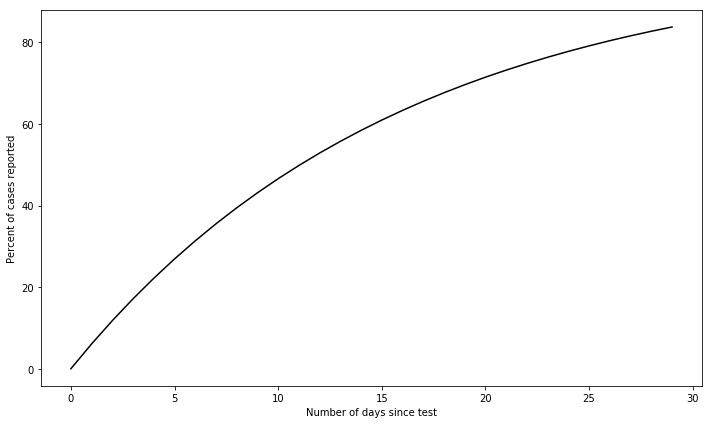

In [5]:
# figure 3
# modeling exponential hazard

x = np.linspace(0,30,30) # days

def complete(r,t): #exponential hazard
    return 1 - np.exp(-r*t)

r = 1/16.5  # 1/average time of onset to reportin

y = complete(r,x)

def lag_cases(y):
    return 1/y

yy = lag_cases(y)


plt.figure(figsize=(10,6))
plt.plot(y*100, c='k')
# plt.plot(yy)
plt.yticks()

plt.xlabel('Number of days since test')
plt.ylabel('Percent of cases reported')
plt.tight_layout()
plt.savefig('./o_figures/figure3.png', dpi=300)

plt.show()



In [6]:
yy

array([        inf, 16.45522432,  8.48544658,  5.83233141,  4.50837677,
        3.71608062,  3.18960761,  2.81502718,  2.53537308,  2.31899652,
        2.14690749,  2.00702078,  1.89127899,  1.79410337,  1.71150864,
        1.64057183,  1.57910034,  1.52541711,  1.47821747,  1.43647112,
        1.39935358,  1.36619719,  1.3364555 ,  1.30967689,  1.28548488,
        1.26356308,  1.24364366,  1.22549836,  1.20893146,  1.19377415])

In [7]:
from datetime import datetime, date
now = datetime.now()
d0 = datetime(2020, 1, 21)

# timespan = now - d0


latest_date = datetime.strptime(Xc['date'].iloc[-1],'%Y-%m-%d')


delta = now-latest_date


In [8]:
Xc = pd.DataFrame(X3)
Xc['total'] = Xc.cumsum()
Xc = Xc.reset_index(drop=False)

Xc = Xc.rename(columns={'accurate_episode_date':'date', 'age_group': 'daily'})

corrected = Xc
days_to_add = len(corrected) - len(yy[:-delta.days])
for ones in range(days_to_add):
    yy = np.append(yy,1)
    
corrected['lag_factor'] = yy[::-1][:-delta.days].tolist() #reverses array

corrected['corrected_daily'] = corrected['daily'] * corrected['lag_factor']
corrected['corrected_total'] = Xc['corrected_daily'].cumsum()

rsquare: 0.9589896463519751


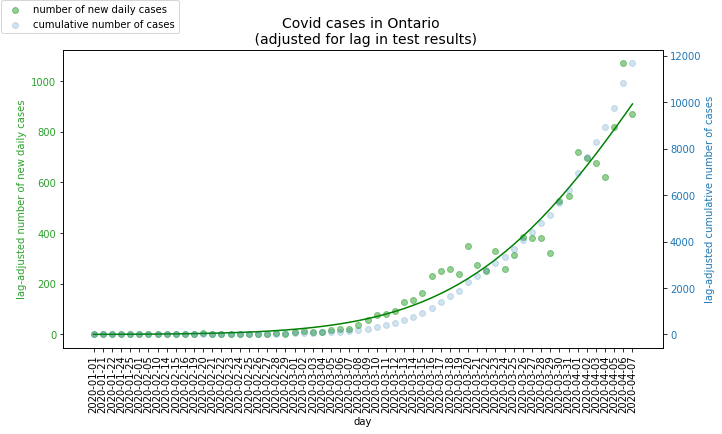

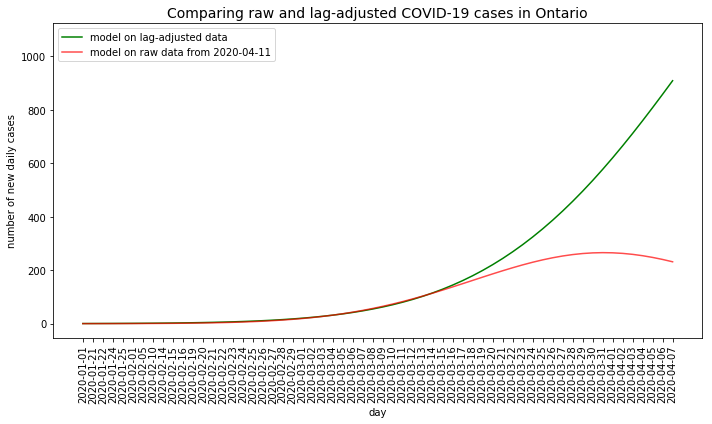

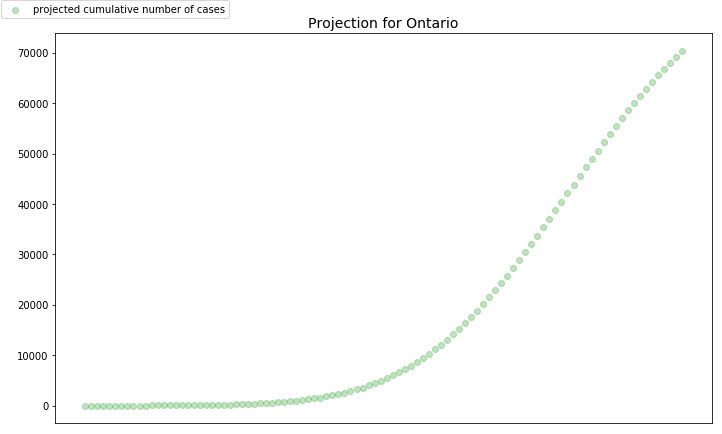

estimated total after 100 days: 70,307


In [9]:
# Figure 5
data1 = [corrected['date'], corrected['corrected_daily']]
data2 = [corrected['date'], corrected['corrected_total']]

fig, ax1 = plt.subplots(facecolor='w', figsize=(10,6))

color = 'tab:green'
ax1.set_xlabel('day')
ax1.set_ylabel('lag-adjusted number of new daily cases', color=color)
ax1.scatter(*data1, color=color, alpha = 0.5, label='number of new daily cases')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=90)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('lag-adjusted cumulative number of cases', color=color)  # we already handled the x-label with ax1
ax2.scatter(*data2, color=color, alpha=0.2, label = 'cumulative number of cases')
ax2.tick_params(axis='y', labelcolor=color)

Xx = np.array(corrected.index)
yy = np.array(corrected['corrected_daily'])

# regression
bounds = ([50,15,0],[20000,90,20])
c_params, params_cov = optimize.curve_fit(fx,Xx,yy, bounds=bounds)
# print(params)

# residuals
residuals = yy - fx(Xx,*c_params)
ssres = np.sum(residuals**2)
sstot = np.sum((yy-np.mean(yy))**2)
rsquared = 1-(ssres/sstot)
print('rsquare: {}'.format(rsquared))

ax1.plot(fx(Xx,*c_params), c='g')
ax1.set_title('Covid cases in {} \n (adjusted for lag in test results)'.format(region), fontsize=14)

fig.legend(borderaxespad=0.1, loc='upper left')

fig.tight_layout()  # otherwise the right y-label is slightly clipped

# plt.tight_layout()

# plt.savefig('./o_figures/figure5.png', dpi=300)

plt.show()


# Figure 6

color = 'k'
fig, ax1 = plt.subplots(facecolor='w', figsize=(10,6))
ax1.set_title('Comparing raw and lag-adjusted COVID-19 cases in {}'.format(region),fontsize=14)

ax1.set_xlabel('day')
ax1.set_ylabel('number of new daily cases', color=color)
ax1.scatter(*data1, color=color, alpha = 0, label='')
ax1.tick_params(axis='y', labelcolor=color)
ax1.tick_params(axis='x', rotation=90)


ax1.plot(fx(Xx,*c_params), c='g', label = 'model on lag-adjusted data')

ax1.plot(fx(Xx,*params), c='r',alpha=0.7, label = 'model on raw data from {}'.format(now.strftime('%Y-%m-%d')))
# ax1.plot(fx(Xx,*params0), c='r',alpha=0.3, label = 'model on raw data from April 2nd')
fig.tight_layout()
plt.legend()
# plt.savefig('./o_figures/figure6.png', dpi=300)

plt.show()


days = 100
t = np.linspace(0,days,days)

y1 = fx(t,*c_params)
red = [Xx, yy]
blue = [t, np.cumsum(y1)]



fig, ax1 = plt.subplots(facecolor='w', figsize=(10,6))
ax1.set_title('Projection for {}'.format(region), fontsize=14)


color = 'tab:green'
ax1.scatter(*blue, color=color, alpha=0.3, label = 'projected cumulative number of cases')


fig.legend(borderaxespad=0.1, loc='upper left')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

plt.tight_layout()


plt.show()

print('estimated total after {0} days: {1:,}'.format(days,int(np.cumsum(y1)[-1])))

In [10]:
corrected

,date,daily,total,lag_factor,corrected_daily,corrected_total
0,2020-01-01,2,2,1.000000,2.000000,2.000000
1,2020-01-21,1,3,1.000000,1.000000,3.000000
2,2020-01-22,1,4,1.000000,1.000000,4.000000
3,2020-01-24,1,5,1.000000,1.000000,5.000000
4,2020-01-25,1,6,1.000000,1.000000,6.000000
5,2020-02-01,1,7,1.000000,1.000000,7.000000
6,2020-02-05,1,8,1.000000,1.000000,8.000000
7,2020-02-10,1,9,1.000000,1.000000,9.000000
8,2020-02-14,2,11,1.000000,2.000000,11.000000
9,2020-02-15,1,12,1.000000,1.000000,12.000000
